<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/pinfish_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Pinfish Tutorial </h1>
The Pinfish tutorial is intended as a simple guide for identifying full length transcripts in your cDNA experiments and comparing them against a known annotation.

We will walk through:

* Identifying full length transcripts,
* Aligning full length transcripts against a reference,
* Generating consensus transcripts,
* Generating a transcriptome from your data,
* Comparing your new transcriptome annotation against a reference transcriptome.

The tutorial is provided with a small sample *Drosophila* transcriptome dataset and can be used to address such questions as:

* How many different full length transcripts are in my sample?
* Which chromosomes are represented by full length transcripts?
* Do I have novel transcripts in my dataset?

Methods used in this tutorial include:

* Python for statistical analysis and reporting, including use of pandas,
* `minimap2`: generating a reference index and aligning, in a *splice-aware* manner, reads against the reference index,
* `samtools`: processing aligned reads,
* `gffcompare`: for manipulating [`.gff`](https://www.ensembl.org/info/website/upload/gff.html) files
* `pychopper`: trimming and orienting cDNA reads,
* `pinfish`: clustering and polishing transcripts. 


The computational requirements for this tutorial include:

* Computer running the EPI2ME Labs notebook Server.
* At least 8 Gb RAM (though more may be needed for larger reference sequences).


⚠️ Warning: This notebook has been saved with its outputs for demonstration purposes. It is recommeded to select Edit > Clear all outputs before using the notebook to analyse your own data.

## Installing Pinfish

The default **EPI2MELabs** server environment does not have Pinfish preinstalled. To use the Pinfish workflow we must therefore first install it and its dependecies. The dependencies are most easily installed with conda; Pinfish itself is comprised of four programs which are freely dowloaded (with `wget`):

In [15]:
# Download the four Pinfish programs
location="https://github.com/nanoporetech/pinfish/blob/v0.1.0"
tools = ["cluster_gff", "collapse_partials", "polish_clusters", "spliced_bam2gff"]
%cd ~/
for tool in tools:
    !echo "Downloading $tool"
    !rm -rf /opt/conda/bin/$tool
    !wget -q -O "$tool" "$location/$tool/$tool?raw=true" \
        && chmod +x "$tool" && mv "$tool" /opt/conda/bin \
    || echo "Could not download $tool"
# Install additional workflow programs with conda
!conda install -y gffcompare gffread pychopper

/home/jovyan


To avoid conflicts with other software, you may wish to restart your EPI2MELabs server when you have finished using Pinfish.

## Data preparation

To start analysing our experiment we must first collate our data. The workflow below expects to be given a single `.fastq` file. 

Before anything else we will create and set a working directory:

In [0]:
# create a work directory and move into it
tutorial_name = "pinfish_tutorial"
working_dir = "/epi2melabs/{}/".format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/pinfish_tutorial


### Sample Sequencing Data

To get started we will download a modest *D. melanogaster* dataset to explore with Pinfish. The workflow also requires a reference sequence and an annotation set.

The form below will download the sample data, reference sequence and annotations. To start the download click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [0]:
# download the data
location='https://ont-research.s3-eu-west-1.amazonaws.com/labs_resources/pychopper_tutorial'
filename = "Dmel.4.filt.fastq.gz"
!echo "Downloading sample data"
!wget -q -O sample_data.fastq.gz "$location"/"$filename"

# download reference and annotations
!echo "Downloading reference sequence"
!wget -q http://ftp.ensembl.org/pub/release-95/fasta/drosophila_melanogaster/dna/Drosophila_melanogaster.BDGP6.dna.toplevel.fa.gz
!echo "Downloading annotation file"
!wget -q http://ftp.ensembl.org/pub/release-95/gtf/drosophila_melanogaster/Drosophila_melanogaster.BDGP6.95.gtf.gz

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value of the `input_file` variable below. To find the correct full path of a file you can navigate to it in the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

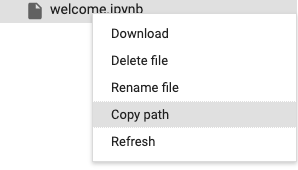

### Data Entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook. This is done in the form below, after updating the values, be sure to press the play button.

The input files may be gzip compressed (and end in the `.gz` suffix). Along with the input files and option is provided to rebuild the alignment index (`rebuild_index`) and specify the number of compute threads (`threads`) to use during computations.

> *A annotation is required only for the final comparison, it is not integral to the workflow.*

In [0]:
#@markdown **Analysis parameters**
import os

fastq = "sample_data.fastq" #@param {type: "string"}
reference = "Drosophila_melanogaster.BDGP6.dna.toplevel.fa" #@param {type: "string"}
annotations = "Drosophila_melanogaster.BDGP6.95.gtf.gz" #@param {type: "string"}
analysis_folder = "analysis" #@param {type: "string"}
rebuild_index = True #@param {type: "boolean"}
threads = 10 #@param {type: "integer"}

!mkdir -p $analysis_folder
to_normalise = zip(
    ('fastq', 'reference', 'annotations'),
    (os.path.basename(x) for x in (fastq, reference, annotations)))

print("Checking files:")
inputs = dict()
for name, fname in to_normalise:
    if name == "annotations" and fname == "":
        continue
    exists = os.path.exists(fname)
    symbol = "✗✓"[exists]
    print("{} {}".format(symbol, fname))
    if not exists:
        continue
    if fname.endswith(".gz"):
        !echo "Unzipping $fname" && gunzip -f $fname
        fname = fname.strip('.gz')
    inputs[name] = fname


Checking files:
✓ sample_data.fastq
✓ Drosophila_melanogaster.BDGP6.dna.toplevel.fa
✓ Drosophila_melanogaster.BDGP6.95.gtf.gz
Unzipping Drosophila_melanogaster.BDGP6.95.gtf.gz


## Sequence data quality control and pre-processing

The following sections run through the Pinfish workflow in a step-wise manner. We will first perform some basic QC with pychopper before clustering and polishing our transcript data.

### Pychopper

The first step of our workflow is to classify, trim and orient the cDNA sequencing data. To do this we will use the cdna_classifier.py software from pychopper. This is a standard step in long read cDNA pipelines and makes subsequent steps easier.

In [0]:
# Run pychopper
pychopper_dir = os.path.join(analysis_folder, "pychopper")
input_file = inputs['fastq']
!mkdir -p $pychopper_dir
!cdna_classifier.py \
    -r "$pychopper_dir"/report.pdf \
    -u "$pychopper_dir"/unclassified.fq \
    -w "$pychopper_dir"/rescued.fq \
    -S "$pychopper_dir"/cdna_classifier_report.tsv \
    "$input_file" \
    "$pychopper_dir"/full_length_output.fq

Configurations to consider: "+:SSP,-VNP|-:VNP,-SSP"
Counting fastq records in input file: sample_data.fastq
Total fastq records in input file: 15076
Tuning the cutoff parameter (q) on 9930 sampled reads (66.3%) passing quality filters (Q >= 7.0).
Optimizing over 30 cutoff values.
100%|███████████████████████████████████████████| 30/30 [08:31<00:00, 17.04s/it]
Best cutoff (q) value is 0.3448 with 81% of the reads classified.
Processing the whole dataset using a batch size of 1884:
100%|████████████████████████████████████| 15076/15076 [00:33<00:00, 452.72it/s]


Before continuing we need to check the pychopper categorization results. To evaluate the results the code box below will summarise the
classification of reads. It will also display a plot illustrating the selection
of the classification decision boundary. This plot should be unimodal (have a single peak).

In [0]:
#@markdown Classification summary *(click to show)*
import os
import pandas as pd
import aplanat
from aplanat import lines

csv = os.path.join(pychopper_dir, "cdna_classifier_report.tsv")

df = pd.read_csv(csv, sep="\t", index_col="Name")
classified = df.loc[df["Category"] == "Classification"] \
    .copy().reset_index().rename(columns={'Name': 'Classification'})
classified["Percentage"] = 100 * classified["Value"] / classified["Value"].sum()
display(classified[['Classification', 'Percentage',]])

tuning =  df.loc[df["Category"] == "AutotuneSample"] \
    .copy().reset_index().rename(columns={'Name': 'Filter'})
plot = lines.line(
    [tuning['Filter'].astype(float)], [tuning['Value']],
    title="Cut off parameter selection curve",
    x_axis_label='Filter cut off',
    y_axis_label='Selected reads')
aplanat.show(plot)

,Classification,Percentage
0,Primers_found,80.098457
1,Rescue,2.047916
2,Unusable,17.853627


### Mapping reads to the reference

Having run pychopper to orient and filter the input sequencing data, we proceed by aligning the data to the provided reference. We will use `minimap2` to perform this task using its *spice aware* mode. This allows reads to be split across introns and span exons. Once minimap2 is finished we process the alignment file (.bam), filter, sort and generate an index (.bai).  

> **A note on alignment file filtering:** the alignment file is filtered such that *secondary* and *supplementary* alignments are removed. The correct placement of a read may be ambiguous, for example from the presence of repeats in the genome. In this case there may be multiple read alignments for the same read. One of these alignments is considered primary. All the other alignments have the secondary alignment flag set. Some alignments of reads cannot be represented as a simple linear alignment. These *chimeric alignments* are represented as a set of linear alignments that do not have large overlaps. Typically one of the linear alignments in a chimeric alignment is considered the “representative” alignment, and the others are called “supplementary”.


In [0]:
#Create the minimap analysis directory
minimap_dir = os.path.join(analysis_folder, "minimap2")
!mkdir -p $minimap_dir

# create minimap index
ref = inputs['reference']
minimap_index = os.path.join(
    analysis_folder, "minimap2", ref + ".mmi")
if rebuild_index or not os.path.exists(minimap_index):
    print("* Building minimap index...")
    !minimap2 -t 10 -k14 -I 1000G -d $minimap_index $ref \
    && "✓ Built index!"
else:
    print("* Skipping building minimap index")

# run minimap, sort, and index the output
minimap_out_bam = os.path.join(minimap_dir, inputs['fastq'] + ".bam")
!minimap2 -t $threads -ax splice -uf \
    $minimap_index "$pychopper_dir"/full_length_output.fq \
    | samtools view -q 10 -F 2304 -Sb \
    | samtools sort -@ 10 - -o $minimap_out_bam
!samtools index $minimap_out_bam

* Building minimap index...
[M::mm_idx_gen::4.865*1.27] collected minimizers
[M::mm_idx_gen::8.039*1.41] sorted minimizers
[M::main::48.335*0.36] loaded/built the index for 1870 target sequence(s)
[M::mm_idx_stat] kmer size: 14; skip: 10; is_hpc: 0; #seq: 1870
[M::mm_idx_stat::48.567*0.36] distinct minimizers: 13579029 (67.42% are singletons); average occurrences: 1.953; average spacing: 5.419
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -t 10 -k14 -I 1000G -d analysis/minimap2/Drosophila_melanogaster.BDGP6.dna.toplevel.fa.mmi Drosophila_melanogaster.BDGP6.dna.toplevel.fa
[M::main] Real time: 48.615 sec; CPU: 17.527 sec; Peak RSS: 0.993 GB
✓ Built index!
[M::mm_idx_gen::4.824*1.21] collected minimizers
[M::mm_idx_gen::8.144*1.33] sorted minimizers
[M::main::45.186*0.33] loaded/built the index for 1870 target sequence(s)
[M::mm_idx_stat] kmer size: 14; skip: 10; is_hpc: 0; #seq: 1870
[M::mm_idx_stat::45.437*0.33] distinct minimizers: 13579029 (67.42% are singletons); average occ

As a brief sanity check of the alignments, we can summarise the information
contained within the alignment `.bam` file and check some basic statistics. The code below will plot a read accuracy histogram together with a histogram depicting the proportion of each read contained within its alignment. This second plot should show a strong peak >98% indicating that the reads align to the reference across their full length.

In [0]:
#@markdown **Read summary plot code** *(click to show)*
# calculate some basic statistics from the alignments
#!stats_from_bam -o $minimap_out_bam'.tsv' $minimap_out_bam

from aplanat import hist
from bokeh.layouts import gridplot
df = pd.read_csv(minimap_out_bam + '.tsv.subset.tsv', sep="\t")

p1 = hist.histogram(
    [df['acc']], xlim=(70,101), binwidth=0.5, height=200,
    x_axis_label='read accuracy', y_axis_label='read count')
p2 = hist.histogram(
    [df['coverage']], xlim=(90,101), binwidth=0.2, height=200,
    x_axis_label='%age of read contained in alignment',
    y_axis_label='read count')

aplanat.show(gridplot([[p1], [p2]]))

### Clustering reads by transcript

In this next stage of the analysis we will cluster reads according to where they have aligned to the reference and create a consensus transcript from each of these clusters.

To obtained high quality transcript sequences and identify probable fragmentation artefacts, we use the four Pinfish tools to:

1.   Convert our `.bam` alignment file produced above to a `.gff` file.
2.   Cluster the reads by transcript identity.
3.   Identify partial and truncated transcripts.
4.   Produce high quality consensus sequences for each transcript.

The first step in this process is achieved with `spliced_bam2gff`:

In [0]:
# covert bam to gff
#@markdown **Pinfish convert**
output_name = "raw_transcripts" #@param {type:"string"}
pinfish_dir = os.path.join(analysis_folder, "pinfish")
!mkdir -p $pinfish_dir

print("* Running spliced_bam2gff..")
pinfish_out_raw_gff = os.path.join(pinfish_dir, output_name + ".gff")
!spliced_bam2gff -s -t $threads -M $minimap_out_bam \
    > $pinfish_out_raw_gff \
    && echo "✓ Completed splice_bam2gff" \
    || echo "✗ Failed splice_bam2gff"

* Running spliced_bam2gff..
✓ Completed splice_bam2gff


Using the `.gff` file we can now cluster reads derived from the same transcipt based on the intron and exon structure described in the file. For the most part the parameters can be left as their default values.

In [0]:
#@markdown **Pinfish cluster**
output_name = "clustered_transcripts" #@param {type:"string"}
minimum_cluster_size = 10 #@param {type:"integer"}
minimum_isoform_percent = 1.0 #@param {type:"number"}
exon_boundary_tolerance = 10 #@param {type:"integer"}
terminal_exon_boundary_tolerance = 30 #@param {type:"integer"}

pinfish_out_cls_gff = os.path.join(pinfish_dir, output_name + ".gff")
pinfish_out_cls_tab = os.path.join(pinfish_dir, output_name + ".tsv")

print("* Running cluster gff")
!cluster_gff \
    -t $threads -c $minimum_cluster_size -p $minimum_isoform_percent \
    -e $exon_boundary_tolerance \
    -d $terminal_exon_boundary_tolerance \
    -a $pinfish_out_cls_tab \
    $pinfish_out_raw_gff > $pinfish_out_cls_gff \
    && echo "✓ Completed cluster gff" \
    || echo "✗ Failed cluster gff"

* Running cluster gff
✓ Completed cluster gff


Before creating consensus sequences for each transcript cluster, we will take a detour and use `collapse partials` to identify artefactual reads.

In [0]:
#@markdown **Pinfish clean up**
output_name = "clustered_collapsed_transcripts" #@param {type:"string"}
collapse_internal_tol = 5 #@param {type:"integer"}
collapse_three_tol = 30 #@param {type:"integer"}
collapse_five_tol = 5000 #@param {type:"integer"}

pinfish_out_cls_col_tab = os.path.join(pinfish_dir, output_name + '.tsv')

print("* Running collapse raw partials")
!collapse_partials \
    -d $collapse_internal_tol -e $collapse_three_tol \
    -f $collapse_five_tol \
    $pinfish_out_cls_gff > $pinfish_out_cls_col_tab \
    && echo "✓ Completed collapse raw partials" \
    || echo "✗ Failed collapse raw partials"

* Running collapse raw partials
✓ Completed collapse raw partials


To create our polished consensus transcript outputs we use Pinfish's `polish_clusters` tool:

In [0]:
#@markdown **Pinfish polish**
output_name = "polished_transcripts.fa" #@param {type:"string"}
minimum_cluster_size = 10 #@param {type:"integer"}

threads=10
pinfish_out_pol_trs = os.path.join(pinfish_dir, output_name)

print("* Running polish clusters")
!polish_clusters \
    -t $threads -a $pinfish_out_cls_tab -c $minimum_cluster_size \
    -o $pinfish_out_pol_trs $minimap_out_bam > /dev/null 2>&1 \
    && echo "✓ Completed polish clusters" \
    || echo "✗ Failed polish clusters"

10
analysis/pinfish/clustered_collapsed_transcripts.tsv
* Running polish clusters
10 analysis/pinfish/clustered_collapsed_transcripts.tsv 10 analysis/minimap2/sample_data.fastq.bam
✓ Completed polish clusters


## Assessing the consensus transcripts

The above workflow should have given higher quality sequences than the input reads, let's check that this is the case be aligning the polished transcripts back to the reference sequence,

In [0]:
# create the minimap analysis directory
minimap_pol_dir = os.path.join(analysis_folder, "minimap2-polished")
!mkdir -p $minimap_pol_dir

# run minimap, sort, and index the output
print("* Running minimap polish clusters")
minimap_out_pol_bam = os.path.join(minimap_pol_dir, inputs['fastq'] + ".bam")
!minimap2 -t $threads -ax splice -uf \
    $minimap_index $pinfish_out_pol_trs \
    | samtools view -q 10 -F 2304 -Sb \
    | samtools sort -@ 10 - -o $minimap_out_pol_bam
!samtools index $minimap_out_bam
print("✓ Completed minimap polish clusters")

* Running minimap polish clusters
[WARNING] Indexing parameters (-k, -w or -H) overridden by parameters used in the prebuilt index.
[M::main::2.850*0.71] loaded/built the index for 1870 target sequence(s)
[M::mm_mapopt_update::3.178*0.74] mid_occ = 133
[M::mm_idx_stat] kmer size: 14; skip: 10; is_hpc: 0; #seq: 1870
[M::mm_idx_stat::3.399*0.75] distinct minimizers: 13579029 (67.42% are singletons); average occurrences: 1.953; average spacing: 5.419
[M::worker_pipeline::3.479*0.79] mapped 151 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -t 10 -ax splice -uf analysis/minimap2/Drosophila_melanogaster.BDGP6.dna.toplevel.fa.mmi analysis/pinfish/polished_transcripts.fa
[M::main] Real time: 3.500 sec; CPU: 2.750 sec; Peak RSS: 0.748 GB
✓ Completed minimap polish clusters


and visualizing the results:

In [0]:
#@markdown **Polished transcript summary plot code** *(click to show)*
# calculate some basic statistics from the alignments
#!stats_from_bam -o $minimap_out_bam'.tsv' $minimap_out_bam

!stats_from_bam -o $minimap_out_pol_bam'.tsv' $minimap_out_pol_bam
!cut -f 1,2,3,18 $minimap_out_pol_bam'.tsv' > $minimap_out_pol_bam'.tsv.subset.tsv'
df_pol = pd.read_csv(minimap_out_pol_bam + '.tsv.subset.tsv', sep="\t")

from aplanat import lines, util
xs, pdes = zip(*(util.kernel_density_estimate(x['acc']) for x in (df, df_pol)))
p1 = lines.line(
    list(xs), list(pdes), names=['reads', 'consensuses'],
    colors=['blue', 'green'], xlim=(80,101), height=200,
    x_axis_label='read accuracy', y_axis_label='read count')
p1.legend.location = 'top_left'
xs, pdes = zip(*(util.kernel_density_estimate(x['coverage']) for x in (df, df_pol)))
p2 = lines.line(
    list(xs), list(pdes), names=['reads', 'consensuses'],
    colors=['blue', 'green'], xlim=(80,101), height=200,
    x_axis_label='%age of read contained in alignment',
    y_axis_label='read count')
p2.legend.location = 'top_left'

aplanat.show(gridplot([[p1], [p2]]))


Mapped/Unmapped/Short/Masked: 151/0/0/0


### Removing truncated polished transcripts

As a final step we will use Pinfish again to remove aligned consensus transcripts that look to be truncated

In [0]:
#@markdown **Pinfish polish bam2gff**
output_name = "polished_transcripts" #@param {type:"string"}

pinfish_out_pol_gff = os.path.join(pinfish_dir, output_name + ".gff") 
pinfish_out_pol_col_gff = os.path.join(pinfish_dir, output_name + "_collapsed.gff") 

print("Final output will be written to: {}".format(pinfish_out_pol_col_gff))

print("* Running Pinfish polish bam2gff")
!spliced_bam2gff \
    -s -t $threads -M $minimap_out_pol_bam \
    > $pinfish_out_pol_gff \
    && echo "✓ Completed Pinfish bam2gff" \
    || echo "✗ Failed Pinfish bam2gff"

print("* Running Pinfish polish partials")
!collapse_partials \
    -d $collapse_internal_tol -e $collapse_three_tol \
    -f $collapse_five_tol \
    $pinfish_out_pol_gff > $pinfish_out_pol_col_gff \
    && echo "✓ Completed Pinfish polish partials" \
    || echo "✗ Failed Pinfish polish partials"

Final output will be written to: analysis/pinfish/polished_transcripts_collapsed.gff
* Running Pinfish polish bam2gff
✓ Completed Pinfish bam2gff
* Running Pinfish polish partials
✓ Completed Pinfish polish partials


### Generating a transcriptome

We now have our finalised transcripts. To create a transcriptome from them we can use `gffread` with the 

In [0]:
#@markdown **Prepare corrected transcriptome fasta**
output_name = "polished_transcriptome.fa" #@param {type:"string"}
pinfish_out_pol_col_fa = os.path.join(pinfish_dir, output_name) 

print("* Running Pinfish corrected transcriptome fasta")
print("Transcriptome will be written to: {}".format(pinfish_out_pol_col_fa))
!gffread \
    -g $ref -w $pinfish_out_pol_col_fa \
    $pinfish_out_pol_col_gff \
    && echo "✓ Completed Output transcriptome fasta" \
    || echo "✗ Failed Output transcriptome fasta"

* Running Pinfish corrected transcriptome fasta
Transcriptome will be written to: analysis/pinfish/polished_transcriptome.fa
FASTA index file Drosophila_melanogaster.BDGP6.dna.toplevel.fa.fai created.
✓ Completed Output transcriptome fasta


## Comparison to existing annotation

The transcriptome generated by the above workflow can be compared to an existing
genome annotation. One result from this analysis can be the discovery of novel transcripts not present in the reference databases.

To create a comparison between the reference annotations and the transcriptome produced by the above workflow we can use `gffcompare`:

In [0]:
#@markdown **Run annotation comparison**
# create a comparison analysis directory
output_name = "gffcompare" #@param {type:"string"}
gffcompare_prefix = os.path.join(analysis_folder, output_name)

print("* Running Gff compare")
if annotations == "":
    print("No annotation file provided at the start of the workflow.")
else:
    annot = inputs['annotations']
    !gffcompare \
        -r $annot -R -M -C -K -o $gffcompare_prefix \
        $pinfish_out_pol_col_gff \
    && echo "✓ Completed gffcompare" \
    || echo "✗ Failed gffcompare"

* Running Gff compare
  34767 reference transcripts loaded.
  3031 duplicate reference transcripts discarded.
  84 query transfrags loaded.
  13 duplicate query transfrags discarded.
✓ Completed gffcompare


Now that `gffcompare` has been run we can investigate the `.tracking` file produced. This gives details on the comparison between the reference annotation and the new annotation produced by this analysis above. A reference guide to the transcript classifications can be found [here](https://ccb.jhu.edu/software/stringtie/gffcompare.shtml#Transcript_classification_codes), though the following table highlights the key details. In *general* novel transcripts will be marked as `u` for unknown.





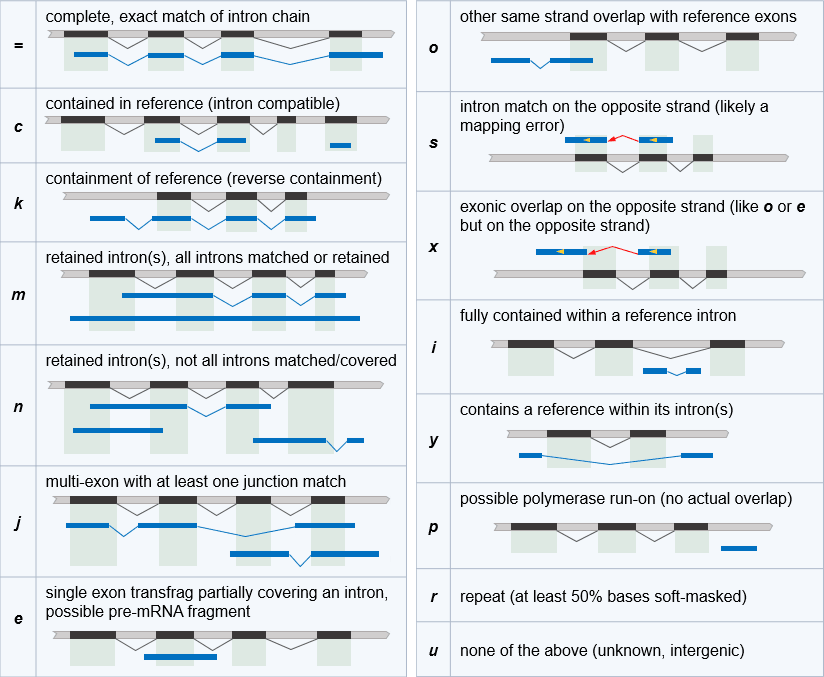

Using the `.tracking` file we can summarise the classifications found:

In [0]:
#@markdown **Classification summary**
tracking_headings = [
    "query_transfrag_id", "query_locus_id", "ref_gene_id",
    "class", "details"]
nice_names = {
    '=': 'complete', 'c': 'contained', 'k': 'containment',
    'm': 'retained', 'n': 'retained (partial)', 'j': 'multi',
    'e': 'single', 'o': 'overlap', 's': 'opposite',
    'x': 'exonic', 'i': 'intron', 'y': 'contains', 'p': 'runon',
    'r': 'repeat', 'u': 'unknown'}

tracking = pd.read_csv(
    gffcompare_prefix + ".tracking", sep="\t",
    names=tracking_headings[1:], index_col=0)

d = pd.DataFrame(tracking['class'].value_counts()) \
    .reset_index().rename(columns={'index':'class', 'class':'count'})
d['description'] = [nice_names[x] for x in d['class']]
display(d)

from aplanat import bars
bars.

# write a separate table for each class
for class_code, table in df.groupby('class_code'):
  path = gffcompare_prefix + ".tracking" + ".{}.tsv".format(class_code)

,class,count,description
0,=,21,complete
1,c,15,contained
2,j,10,multi
3,n,2,retained (partial)
4,s,2,opposite
5,u,1,unknown


## Summary

In this tutorial we have worked through analysis of Oxford Nanopore Technologies' cDNA sequencing data. We first aligned the reads to a reference genome, using the reference to cluster reads. From the clustered reads we generated polished consensus sequences and identified reads that were likely not full-length transcripts.

In a final step we compared the produced transcriptome to a reference annotation set to identify novel transcripts.
